In [4]:
!git clone https://github.com/Esri/arcgis-python-api.git

Cloning into 'arcgis-python-api'...
remote: Enumerating objects: 30946, done.
remote: Counting objects: 100% (2668/2668), done.
remote: Compressing objects: 100% (534/534), done.
remote: Total 30946 (delta 2444), reused 2231 (delta 2132), pack-reused 28278
Receiving objects: 100% (30946/30946), 2.68 GiB | 24.98 MiB/s, done.
Resolving deltas: 100% (13839/13839), done.
Checking out files: 100% (9448/9448), done.


In [7]:
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 35.1 MB 167 kB/s 


### 1. Data exploration

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
        return datetime.strptime(x, '%Y0%m')
enso_original_path = os.path.join('.', 'data', 'enso_original.csv')
df = read_csv(r'/content/enso_original.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
start = 336 
df = df.iloc[start:]
df = (df - df.mean()) / df.std()
print(df.head())

                 soi       oni     nino3       pna  Unnamed: 5
date                                                          
1979-01-01 -0.441750 -0.059963 -0.150376 -1.537109         NaN
1979-02-01  0.997371  0.056451 -0.271512 -2.725606         NaN
1979-03-01  0.072222  0.172865 -0.139364  0.080846         NaN
1979-04-01 -0.133367  0.289280  0.213033 -0.148864         NaN
1979-05-01  0.483399  0.172865  0.036835  1.269344         NaN


<ipython-input-1-7db91f36738f>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Text(0.5, 0, 'Time')

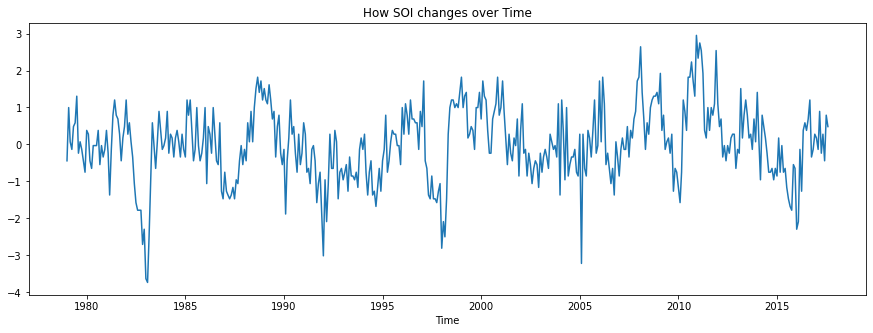

In [2]:
pyplot.figure(figsize=(15,5))
pyplot.plot(df.soi)
pyplot.title('How SOI changes over Time')
pyplot.xlabel('Time')

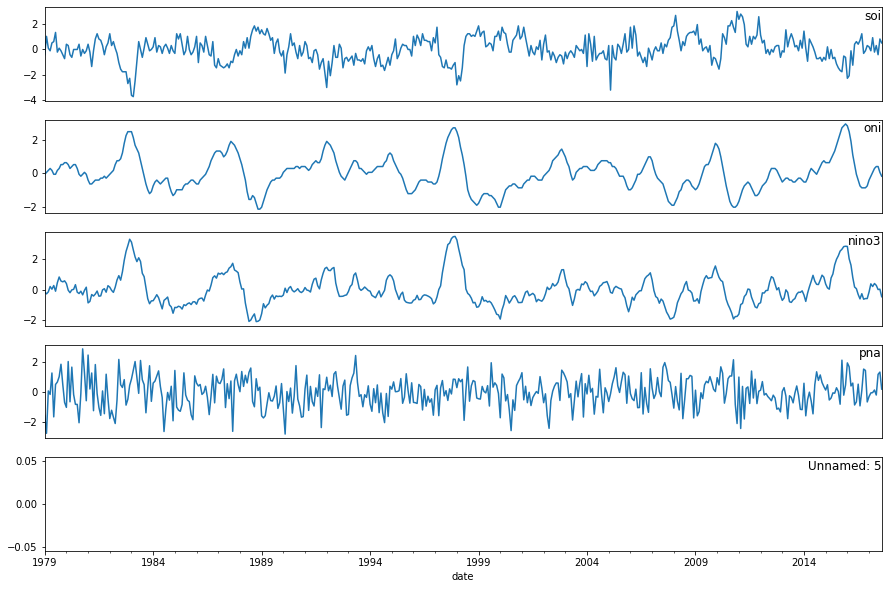

In [3]:
i = 1
fig = pyplot.figure(figsize=(15,10))
for col in df.columns.tolist():
    fig.add_subplot(len(df.columns.tolist()), 1, i)
    df[col].plot()
    pyplot.title(col, y=0.8, loc='right')
    if i != len(df.columns.tolist()):
        pyplot.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        pyplot.xlabel('')
    i += 1
pyplot.show()

### 2. Correlation analysis

(72, 144, 466)


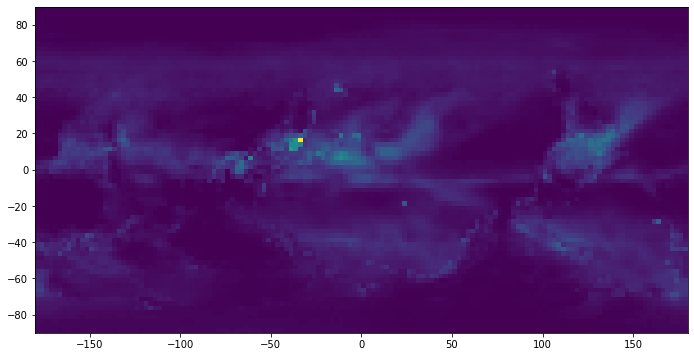

In [10]:
from skimage import io
import math
from scipy.stats.stats import pearsonr
from numpy import unravel_index

precipitation_path = os.path.join('data', 'precipitation.tif')
precip_full = io.imread(precipitation_path)
precip_full = np.flip(precip_full, 0)

# print the dimension of the precip_full, (lat, lon, time)
print(precip_full.shape)
# let's print out the first month/band of this data
pyplot.figure(figsize=(15,6))
pyplot.imshow(precip_full[:,:,0], extent=[-180, +180, -90, 90])

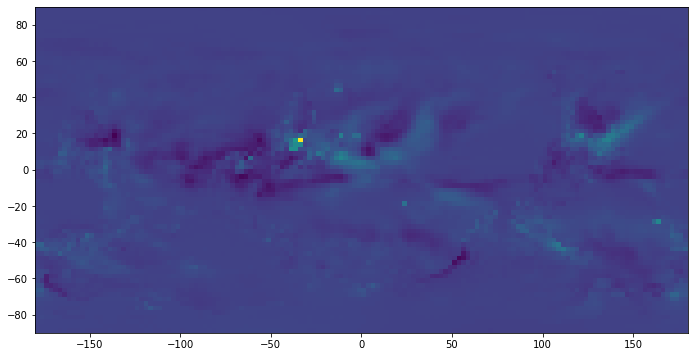

In [11]:
# calculate the historical mean for each month
a = np.zeros(shape = (precip_full.shape[0], precip_full.shape[1], math.ceil(precip_full.shape[2]/12)*12))
a[:,:,0:precip_full.shape[2]] = precip_full
a = a.reshape(a.shape[0], a.shape[1], int(a.shape[2]/12), 12)
monthly_sum = np.sum(a, axis=2)

montly_mean_1_10 = monthly_sum[:,:,0:10]/a.shape[2]
montly_mean_11_12 = monthly_sum[:,:,-2:]/(a.shape[2] - 1)
monthly_mean = np.append(montly_mean_1_10, montly_mean_11_12, axis=2)

# calculate the difference
for i in range(a.shape[3]):
    a[:,:,i,:] -=monthly_mean

# reshape the data back to its orginial dimension
a = a.reshape(a.shape[0], a.shape[1], a.shape[2]*a.shape[3])

# visualize the first month anomaly
pyplot.figure(figsize=(15,6))
pyplot.imshow(a[:,:,0], extent=[-180, +180, -90, 90])

In [12]:
df.shape

(464, 5)

### 3. Time Series Analysis/LSTM

#### 3.1 Data cleanup and transformation

In [26]:
%matplotlib inline
import os.path
import warnings
import numpy as np
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import datetime
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
warnings.filterwarnings('ignore')

def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
        return datetime.strptime(x, '%Y0%m')
enso_ready_path = os.path.join('.', 'data', 'enso_ready.csv')
df = read_csv(enso_ready_path, header=0, parse_dates=[0], index_col=0, date_parser=parser)
df.head()

<ipython-input-26-3cac217e571b>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


,soi,oni,nino3,pna,precip
date,,,,,
1951-01-01,1.5,-0.8,-0.72,-1.18,NaN
1951-02-01,0.9,-0.5,-0.43,-2.11,NaN
1951-03-01,-0.1,-0.2,-0.63,-1.09,NaN
1951-04-01,-0.3,0.2,0.00,0.47,NaN
1951-05-01,-0.7,0.4,-0.12,1.19,NaN


In [27]:
start = 336 
df = df.iloc[start:]
df = (df - df.mean()) / df.std()

cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]
df.head()

,oni,nino3,pna,precip,soi
date,,,,,
1979-01-01,-0.059963,-0.150376,-1.537109,1.424196,-0.441750
1979-02-01,0.056451,-0.271512,-2.725606,0.200227,0.997371
1979-03-01,0.172865,-0.139364,0.080846,-0.530831,0.072222
1979-04-01,0.289280,0.213033,-0.148864,-0.755133,-0.133367
1979-05-01,0.172865,0.036835,1.269344,-0.270530,0.483399


In [28]:
"""
This method takes a time series and returns transformed data.
data: time series as pandas dataframe
n_in: number of previous time steps as input (X)
n_out: number of next time steps as output (y)
dropnan: whether or not to drop rows with NaN values
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i).iloc[:,-1])
        if i == 0:
            names += ['VAR(t)']
        else:
            names += ['VAR(t+%d)' % i]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [29]:
# specify the size of our sliding window and number of features
enso = df.values.astype('float32')
lag = 12
ahead = 3
n_features = 1
reframed = series_to_supervised(enso, lag, ahead)
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),VAR(t),VAR(t+1),VAR(t+2)
12,-0.059963,-0.150376,-1.537109,1.424196,-0.441750,0.056451,-0.271512,-2.725606,0.200227,0.997371,...,0.061769,-0.441750,0.638523,0.587453,-0.678194,-0.032382,-0.750133,0.380605,0.277811,-0.441750
13,0.056451,-0.271512,-2.725606,0.200227,0.997371,0.172865,-0.139364,0.080846,-0.530831,0.072222,...,-0.032382,-0.750133,0.638523,0.411255,-1.007778,-0.076689,0.380605,0.277811,-0.441750,-0.647339
14,0.172865,-0.139364,0.080846,-0.530831,0.072222,0.289280,0.213033,-0.148864,-0.755133,-0.133367,...,-0.076689,0.380605,0.522109,-0.029240,2.028384,-0.804978,0.277811,-0.441750,-0.647339,-0.030572
15,0.289280,0.213033,-0.148864,-0.755133,-0.133367,0.172865,0.036835,1.269344,-0.270530,0.483399,...,-0.804978,0.277811,0.289280,-0.194425,-0.638245,0.269456,-0.441750,-0.647339,-0.030572,-0.030572
16,0.172865,0.036835,1.269344,-0.270530,0.483399,-0.059963,0.279107,-1.636982,-0.068382,0.586194,...,0.269456,-0.441750,0.405694,-0.007215,1.658851,-0.359143,-0.647339,-0.030572,-0.030572,-0.030572


#### 3.2 Model training

In [30]:
"""
This method takes training data and returns a LSTM model
train: training data
n_lag: number of previous time steps
n_ahead: number of next time steps
nb_epoch: number of epochs
n_neurons: number of n_neurons in the first layer
"""
def fit_lstm(train, n_lag, n_ahead, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, :-n_ahead], train[:, -n_ahead:]
    X = X.reshape(X.shape[0], n_lag, int(X.shape[1]/n_lag))

    # design neural network architecture. This is a simple LSTM just for demo purpose
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(n_ahead))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit the NN
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=2, shuffle=False)
        model.reset_states()
    return model

In [31]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

# fit a LSTM model with the transformed data
# model fitting can be very time-consuming, therefore a pre-trained model is included in the data folder
model_path = os.path.join('.', 'data', 'my_model.h5')
if not os.path.exists(model_path):
    model = fit_lstm(train, lag, ahead, 1, 30, 30)
    model.save(model_path)
else:
    model = load_model(model_path)

360/360 - 4s - loss: 0.7374 - 4s/epoch - 10ms/step
360/360 - 1s - loss: 0.5943 - 1s/epoch - 4ms/step
360/360 - 1s - loss: 0.5413 - 1s/epoch - 4ms/step
360/360 - 1s - loss: 0.5063 - 1s/epoch - 3ms/step
360/360 - 1s - loss: 0.4794 - 1s/epoch - 3ms/step
360/360 - 1s - loss: 0.4572 - 1s/epoch - 4ms/step
360/360 - 1s - loss: 0.4430 - 1s/epoch - 3ms/step
360/360 - 1s - loss: 0.4262 - 1s/epoch - 4ms/step
360/360 - 1s - loss: 0.4067 - 1s/epoch - 3ms/step
360/360 - 1s - loss: 0.3905 - 1s/epoch - 4ms/step
360/360 - 2s - loss: 0.3822 - 2s/epoch - 6ms/step
360/360 - 3s - loss: 0.3819 - 3s/epoch - 7ms/step
360/360 - 2s - loss: 0.3728 - 2s/epoch - 6ms/step
360/360 - 2s - loss: 0.3477 - 2s/epoch - 6ms/step
360/360 - 2s - loss: 0.3402 - 2s/epoch - 6ms/step
360/360 - 3s - loss: 0.3205 - 3s/epoch - 7ms/step
360/360 - 2s - loss: 0.3085 - 2s/epoch - 6ms/step
360/360 - 2s - loss: 0.3002 - 2s/epoch - 5ms/step
360/360 - 1s - loss: 0.2882 - 1s/epoch - 3ms/step
360/360 - 2s - loss: 0.2804 - 2s/epoch - 5ms/step

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 30)                   4320      
                                                                 
 dense (Dense)               (1, 3)                    93        
                                                                 
Total params: 4,413
Trainable params: 4,413
Non-trainable params: 0
_________________________________________________________________


#### 3.3 Prediction and evaluation

In [33]:
# predict the SOI values for next three time steps given a single input sample 
def forecast_lstm(model, X, n_batch, n_lag):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, n_lag, int(len(X)/n_lag))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# make prediciton for a list of input samples
def make_forecasts(model, n_batch, train, test, n_lag, n_ahead):
    forecasts = list()
    for i in range(len(test)):
        X = test[i, :-n_ahead]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch, n_lag)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [34]:
forecasts = make_forecasts(model, 1, train, test, lag, ahead)
# pring out the output for the first input sample
forecasts[0]

1/1 [==============================] - 0s 17ms/step


[-0.9431088, -1.3279331, -1.3796792]

In [35]:
def evaluate_forecasts(y, forecasts, n_lag, n_seq):
    print('Evaluation results (RMSE) for each next tim step:')
    for i in range(n_seq):
        actual = [row[i] for row in y]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d time step: %f' % ((i+1), rmse))
        
# evaluate forecasts
actual = [row[-ahead:] for row in test]
evaluate_forecasts(actual, forecasts, lag, ahead)

Evaluation results (RMSE) for each next tim step:
t+1 time step: 0.788429
t+2 time step: 0.787712
t+3 time step: 0.889866


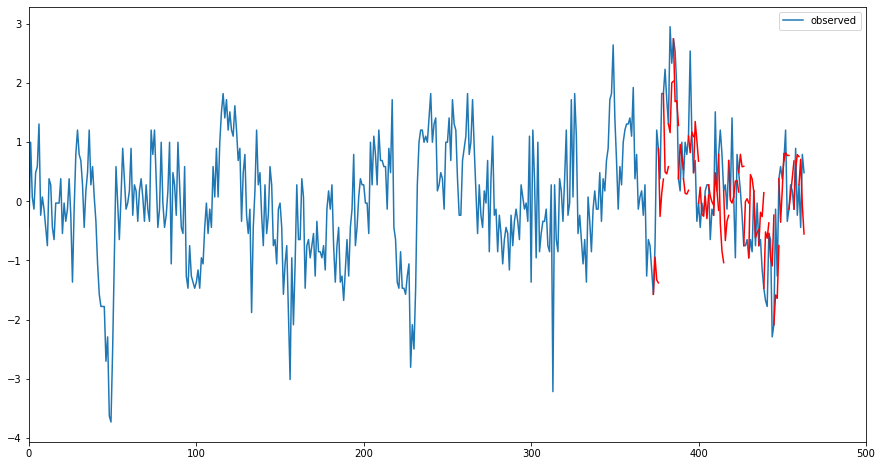

In [36]:
# plot the forecasts in the context of the original dataset, multiple segments
def plot_forecasts(series, forecasts, n_test, xlim, ylim, n_ahead, linestyle = None):
    pyplot.figure(figsize=(15,8))
    if linestyle==None:
        pyplot.plot(series, label='observed')
    else:
        pyplot.plot(series, linestyle, label='observed')
    pyplot.xlim(xlim, ylim)
    pyplot.legend(loc='upper right')
    # plot the forecasts in red
    for i in range(len(forecasts)):
        # this ensures not all segements are plotted, it is plotted every n_ahead
        if i%n_ahead ==0:
               off_s = len(series) - n_test + 2 + i - 1
               off_e = off_s + len(forecasts[i]) + 1
               xaxis = [x for x in range(off_s, off_e)]
               yaxis = [series[off_s]] + forecasts[i] 
               pyplot.plot(xaxis, yaxis, 'r')
    pyplot.show()
    
plot_forecasts(df['soi'].values, forecasts, test.shape[0] + ahead - 1, 0, 500, ahead)